In [241]:
import os
BAR = 'Barcodes_1d'
ROOT = open('../root').read().strip()
print ROOT
img_path = os.path.join(ROOT, 'common')
print img_path
anno_path = os.path.join(ROOT, BAR, 'annotations.json')
print anno_path
empty_path = os.path.join(ROOT, 'Empty', 'annotations.json')
print empty_path

/home/nik-kochetov/work
/home/nik-kochetov/work/common
/home/nik-kochetov/work/Barcodes_1d/annotations.json
/home/nik-kochetov/work/Empty/annotations.json


In [242]:
import model
reload(model)

<module 'model' from 'model.pyc'>

In [243]:
import converter
from model import SSDModel, PixelsModel
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
%matplotlib inline

In [244]:
model = SSDModel()

In [245]:
path = os.path.join(ROOT, 'edge_models', 'model.23-05-2018.gen3.13_ssd_only_edges.ssd.09.hdf5')
model.model.load_weights(path)

In [246]:
import json
with open(anno_path) as f:
    annos = json.loads(f.read())
print len(annos)
print annos[0]

with open(empty_path) as f:
    empty_annos = json.loads(f.read())
print len(empty_annos)
print empty_annos[0]

all_annos = annos + empty_annos

8111
{u'name': u'0001.jpg', u'shape': [3585, 2661, 3], u'Rects': [[594, 1081, 326, 575], [568, 1054, 1131, 1382], [593, 1074, 718, 968], [572, 1057, 1566, 1817], [564, 1050, 1964, 2217], [567, 1048, 2437, 2691]], u'path': u'Barcodes_1d/UPC-E', u'id': u'0001', u'Types': [u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE', u'UPCE']}
10156
{u'Rects': [], u'path': u'Empty', u'shape': [4400, 3400, 3], u'name': u'9468_020.4B.tif.jpg', u'Types': []}


In [247]:
import generator
reload(generator)
from generator import Generator
ssd_generator = Generator(ROOT, model)

In [248]:
generator = ssd_generator.generate(all_annos, 512*512*1, True)

In [249]:
gen = next(generator)

next batch:
('img:', u'Barcodes_1d/Interleaved 2 of 5 (2)/0059.jpg')
('window: ', Rect(140, 464, 1164, 1488))
('tensors:', [(0, 1, 0.0, 0.8515625, 1.0, 1.0, 0.1484375), (1, 1, 0.0, 0.0, 1.0, 0.859375, 0.859375), (0, 2, 0.0, 0.8515625, 1.0, 1.0, 0.1484375), (1, 2, 0.0, 0.0, 1.0, 0.859375, 0.859375), (0, 3, 0.0, 0.8515625, 1.0, 1.0, 0.1484375), (1, 3, 0.0, 0.0, 1.0, 0.859375, 0.859375), (0, 4, 0.0, 0.8515625, 1.0, 1.0, 0.1484375), (1, 4, 0.0, 0.0, 1.0, 0.859375, 0.859375), (0, 5, 0.0, 0.8515625, 1.0, 1.0, 0.1484375), (1, 5, 0.0, 0.0, 1.0, 0.859375, 0.859375), (0, 6, 0.0, 0.8515625, 1.0, 1.0, 0.1484375), (1, 6, 0.0, 0.0, 1.0, 0.859375, 0.859375), (5, 0, 0.1953125, 0.59375, 1.0, 1.0, 0.326904296875), (6, 0, 0.1953125, 0.0, 1.0, 0.5859375, 0.47149658203125), (5, 1, 0.0, 0.59375, 1.0, 1.0, 0.40625), (6, 1, 0.0, 0.0, 1.0, 0.5859375, 0.5859375), (5, 2, 0.0, 0.59375, 1.0, 1.0, 0.40625), (6, 2, 0.0, 0.0, 1.0, 0.5859375, 0.5859375), (5, 3, 0.0, 0.59375, 1.0, 1.0, 0.40625), (6, 3, 0.0, 0.0, 1.0, 0

In [250]:
print gen[0]['input'].shape
print gen[1]['lr_bbox'].shape
print gen[1]['tb_bbox'].shape
print gen[1]['class'].shape

(1, 512, 512, 3)
(1, 8, 8, 3)
(1, 8, 8, 3)
(1, 8, 8, 2)


In [251]:
def unprocess(y):
        x = np.copy(y)
        # Zero-decenter by mean pixel
        x[:, :, :, 0] += 103.939
        x[:, :, :, 1] += 116.779
        x[:, :, :, 2] += 123.68

        # 'BGR'->'RGB'
        x = x[:, :, :, ::-1]
        print np.max(x), np.min(x)
        return x / 256.0

In [252]:
img = unprocess(gen[0]['input'])[0]
lr =  gen[1]['lr_bbox'][0]
tb = gen[1]['tb_bbox'][0]
cls = gen[1]['class'][0,:,:,1]
print np.mean(lr), np.var(lr), np.min(lr), np.max(lr)
print np.mean(tb), np.var(tb), np.min(tb), np.max(tb)

255.0 0.0
0.214396158854 0.163575289978 0.0 1.0
0.327433268229 0.186993120445 0.0 1.0


In [253]:
def plot_edges(ax, tensor, mask, is_lr, edge=64, ct='b', cb='r'):
    
    def draw(x, y, val, col):
        if is_lr:
            sx, sy, dx, dy = (x + val) * edge, y * edge, 0, edge
        else:
            sx, sy, dx, dy = x * edge, (y + val) * edge, edge, 0
            
        #print x, y, val, ' -> ', sx, sy, dx, dy
        ar = patches.Arrow(sx, sy, dx, dy, color=col)
        ax.add_patch(ar)

    
    assert len(mask.shape) == 2
    h, w = mask.shape
    for y in range(h):
        for x in range(w):
            if mask[y][x] > 0:
                draw(x, y, tensor[y,x,0], ct)
                draw(x, y, 1.0 - tensor[y,x,1], cb)

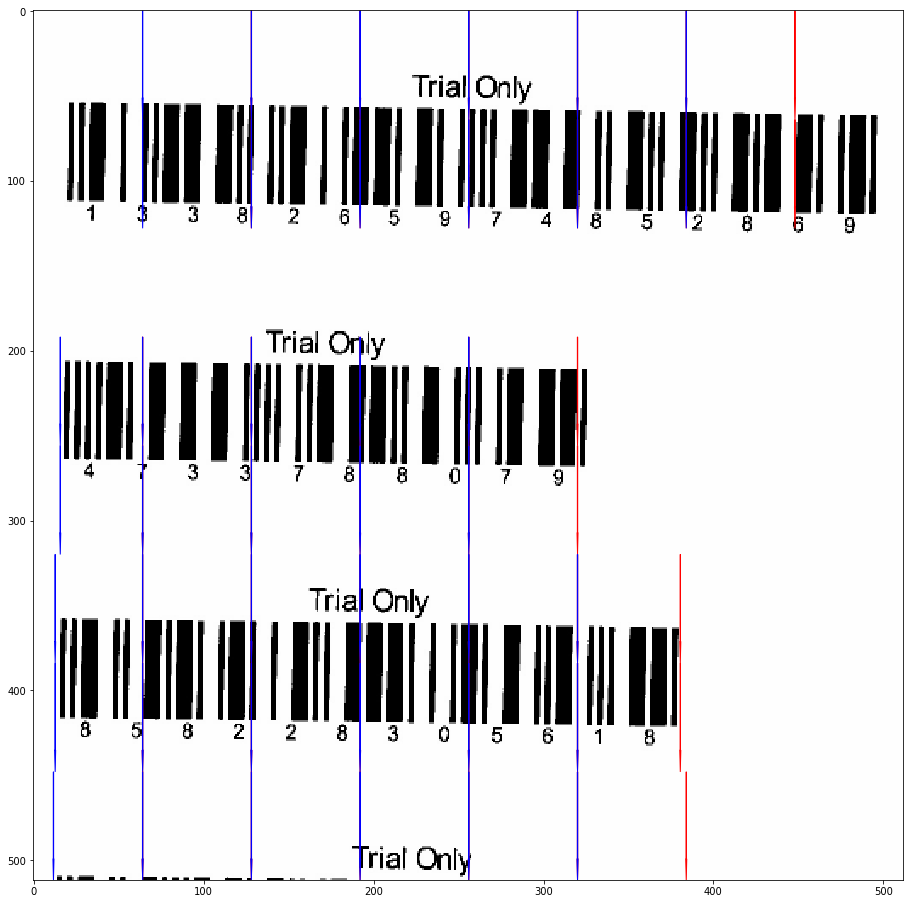

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
plot_edges(ax, lr, cls, True)
#ax.imshow(cls, cmap='gray')
ax.imshow(img)

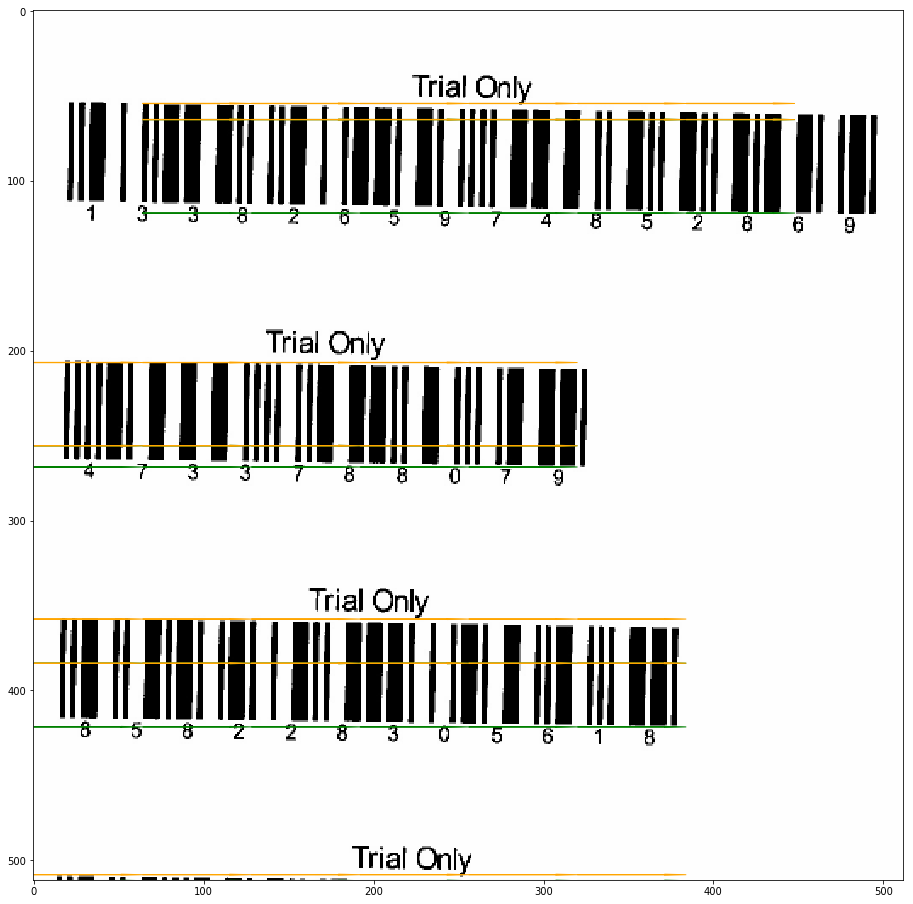

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
plot_edges(ax, tb, cls, False, ct='orange', cb='g')
#ax.imshow(cls, cmap='gray')
ax.imshow(img)

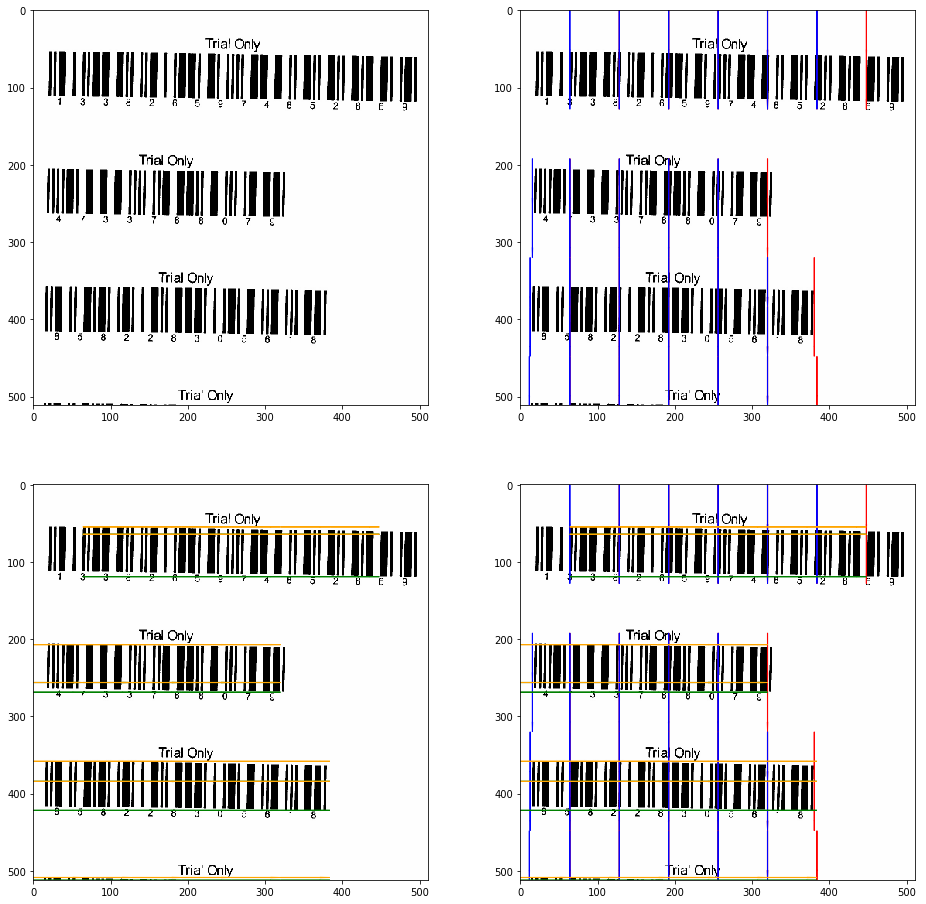

In [256]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
#show_img_from_gen(ax1, gen[0])
ax1.imshow(img)
plot_edges(ax2, lr, cls, True)
ax2.imshow(img)
plot_edges(ax3, tb, cls, False, ct='orange', cb='g')
ax3.imshow(img)
plot_edges(ax4, lr, cls, True)
plot_edges(ax4, tb, cls, False, ct='orange', cb='g')
ax4.imshow(img)

In [257]:
tensor = model.model.predict(gen[0])

In [258]:
print len(tensor)
print tensor[0].shape
print tensor[1].shape

2
(1, 8, 8, 2)
(1, 8, 8, 2)


In [259]:
img = unprocess(gen[0]['input'])[0]
lr =  tensor[0][0]
tb = tensor[1][0]
cls = gen[1]['class'][0,:,:,1]
print np.mean(lr), np.var(lr), np.min(lr), np.max(lr)
print np.mean(tb), np.var(tb), np.min(tb), np.max(tb)

255.0 0.0
0.0768034 0.0360068 -0.0245565 0.967917
0.300544 0.103371 -0.00660463 0.94745


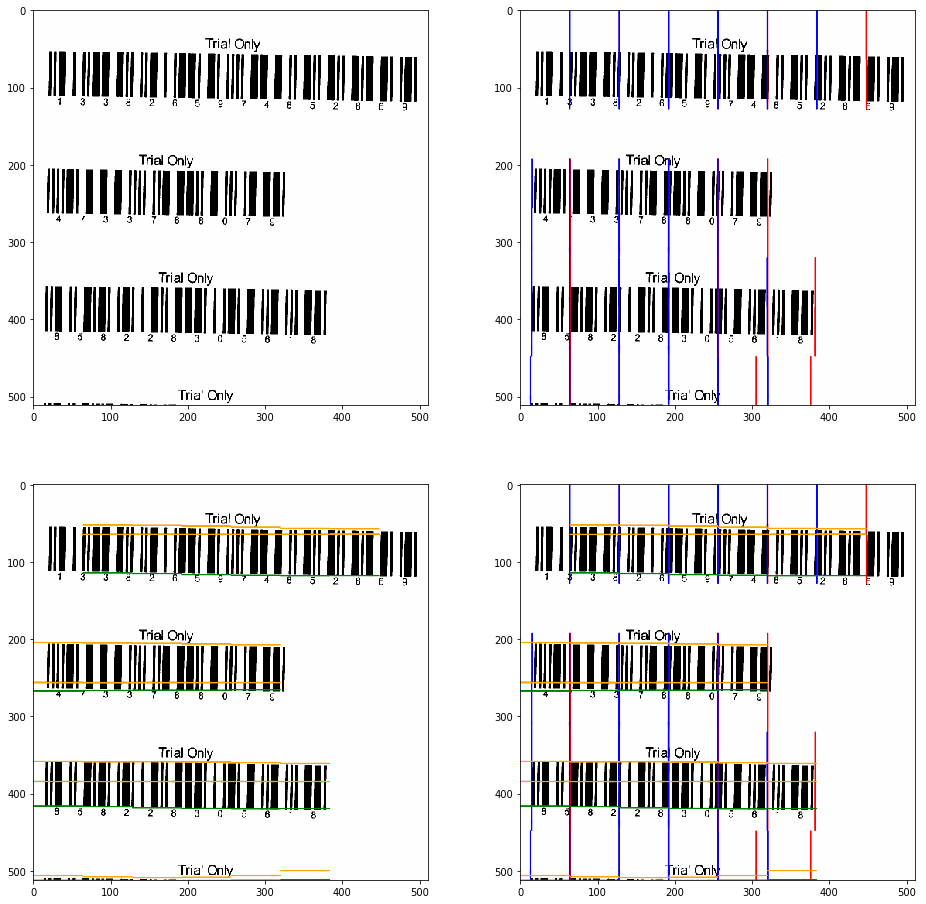

In [260]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
#show_img_from_gen(ax1, gen[0])
ax1.imshow(img)
plot_edges(ax2, lr, cls, True)
ax2.imshow(img)
plot_edges(ax3, tb, cls, False, ct='orange', cb='g')
ax3.imshow(img)
plot_edges(ax4, lr, cls, True)
plot_edges(ax4, tb, cls, False, ct='orange', cb='g')
ax4.imshow(img)

(10, 2)
next batch:
('img:', u'Barcodes_1d/Code 39.Code 32 Ideal/0079.jpg')
('window: ', Rect(0, 0, 1024, 1024))
('tensors:', [])
255.0 0.0
next batch:
('img:', u'Barcodes_1d/EAN 13/0897.jpg')
('window: ', Rect(314, 1286, 2362, 3334))
('tensors:', [(7, 0, 0.01171875, 0.20703125, 1.0, 0.98046875, 0.764373779296875), (7, 1, 0.0, 0.20703125, 1.0, 0.98046875, 0.7734375), (7, 2, 0.0, 0.20703125, 0.3046875, 0.98046875, 0.23565673828125)])
255.0 0.0
next batch:
('img:', u'Barcodes_1d/Wide Barcodes 1D (3)/0144.jpg')
('window: ', Rect(1406, 35, 2430, 1059))
('tensors:', [(0, 3, 0.2265625, 0.0859375, 1.0, 0.7578125, 0.5196533203125), (0, 4, 0.0, 0.0859375, 1.0, 0.7578125, 0.671875), (0, 5, 0.0, 0.0859375, 1.0, 0.7578125, 0.671875), (0, 6, 0.0, 0.0859375, 0.5, 0.7578125, 0.3359375)])
255.0 0.0
next batch:
('img:', u'Barcodes_1d/Wide Barcodes 1D (4)/0130.jpg')
('window: ', Rect(1780, 59, 2292, 571))
('tensors:', [(0, 0, 0.28125, 0.078125, 1.0, 1.0, 0.66259765625), (1, 0, 0.28125, 0.0, 1.0, 0.39062

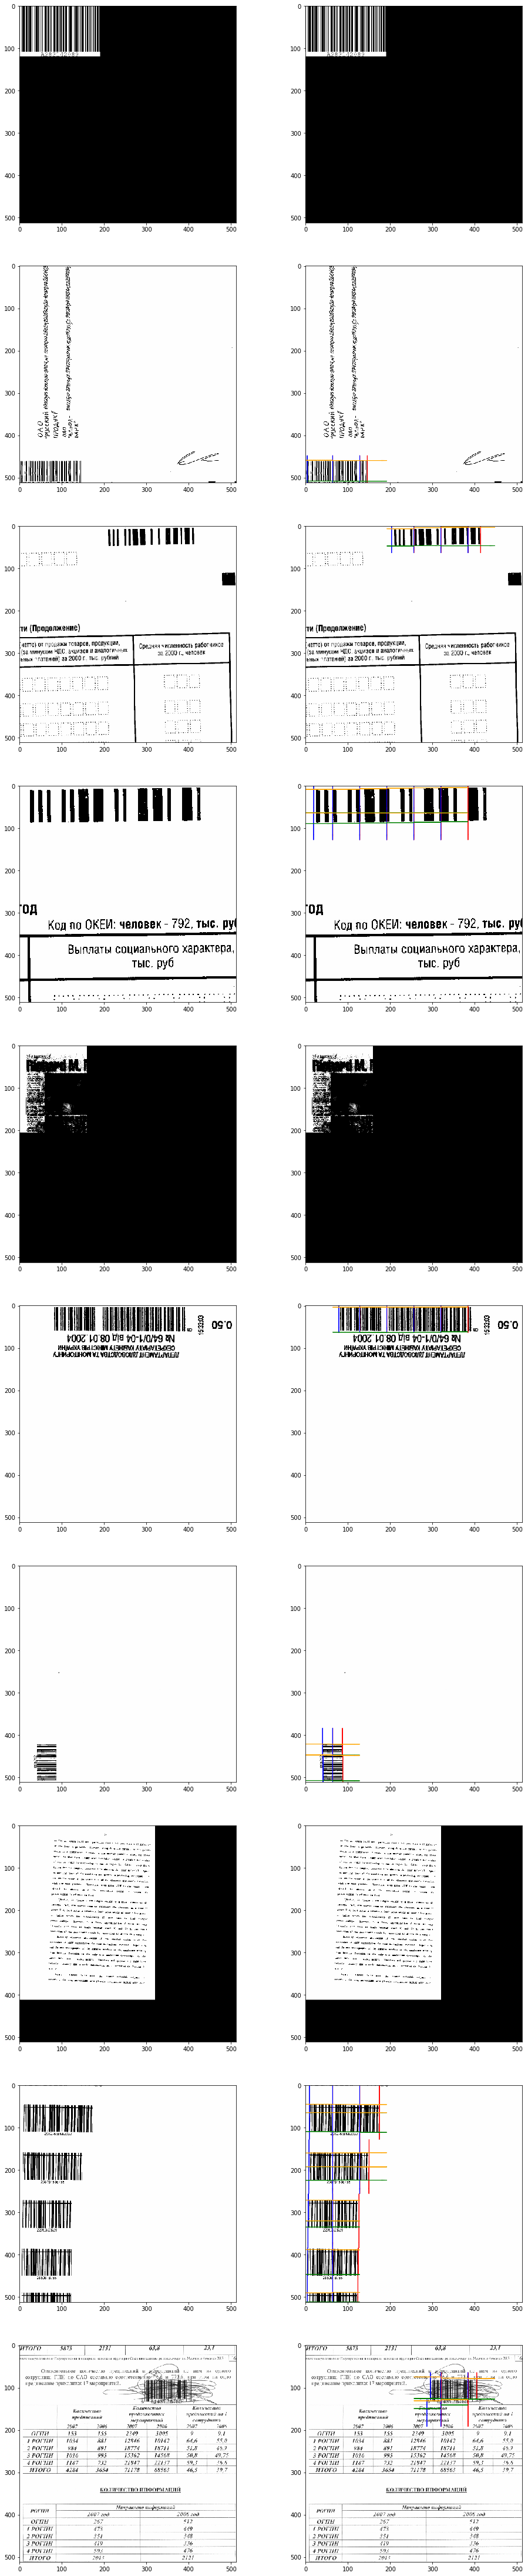

In [261]:
count = 10

fig, axes = plt.subplots(count, 2, figsize=(16, 8 * count))
print axes.shape

for i in range(count):
    gen = next(generator)
    tensor = model.model.predict(gen[0])
    
    img = unprocess(gen[0]['input'])[0]
    lr =  tensor[0][0]
    tb = tensor[1][0]
    cls = gen[1]['class'][0,:,:,1]
    
    axes[i][0].imshow(img)
    
    plot_edges(axes[i][1], lr, cls, True)
    plot_edges(axes[i][1], tb, cls, False, ct='orange', cb='g')
    axes[i][1].imshow(img)